In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
np.set_printoptions(suppress=True)
sns.set(style='whitegrid')

In [22]:
#1. Load training data
input_path = 'data/train.csv'
train_data = pd.read_csv(input_path, index_col='Id')

#1a. Train Data (rows , coulmns)
print("Feature Matrix size : ", train_data.shape)

Feature Matrix size :  (1460, 80)


In [23]:
'''
2. Check if any train_data columns contain missing/NULL values.
If yes, fill missing data appropriately.
'''
null_train_data = train_data.columns[train_data.isnull().any()]
missing_ratio = (train_data[null_train_data].isnull().sum()/len(train_data)) * 100
missing_data = pd.DataFrame({'Missing Ratio' :missing_ratio})
missing_data.sort_values(by='Missing Ratio',ascending=False)

,Missing Ratio
PoolQC,99.52
MiscFeature,96.30
Alley,93.77
Fence,80.75
FireplaceQu,47.26
LotFrontage,17.74
GarageType,5.55
GarageYrBlt,5.55
GarageFinish,5.55
GarageQual,5.55


In [24]:
'''
3. Fill missing feature values
'''
for col in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']:
    train_data[col] = train_data[col].fillna('None')

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'MasVnrType']:
    train_data[col] = train_data[col].fillna('None')
    
for col in ['BsmtExposure', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtFinType1']:
    train_data[col] = train_data[col].fillna('None')
    
'''
No GarageYrBlt means no Garage. We cannot impute mean/median since it would 
incorrectly convey existence of Garage. same reasoning for MasVnrArea.
'''
for col in ['GarageYrBlt', 'MasVnrArea']:
    train_data[col] = train_data[col].fillna(0)
    
'''
Group data by neighborhood & imputed null LotFrontage columns with median of
grouped data.
'''
train_data['LotFrontage'] = train_data.groupby(['Neighborhood'])\
                    ['LotFrontage'].transform(lambda x : x.fillna(x.median()))

train_data['Electrical'] = \
    train_data['Electrical'].fillna(train_data['Electrical'].mode()[0])
    
null_train_data = train_data.columns[train_data.isnull().any()]
missing_ratio = (train_data[null_train_data].isnull().sum()/len(train_data)) * 100
missing_data = pd.DataFrame({'Missing Ratio' :missing_ratio})
print(missing_data.sort_values(by='Missing Ratio',ascending=False))

Empty DataFrame
Columns: [Missing Ratio]
Index: []


Number of Numerical features : 37


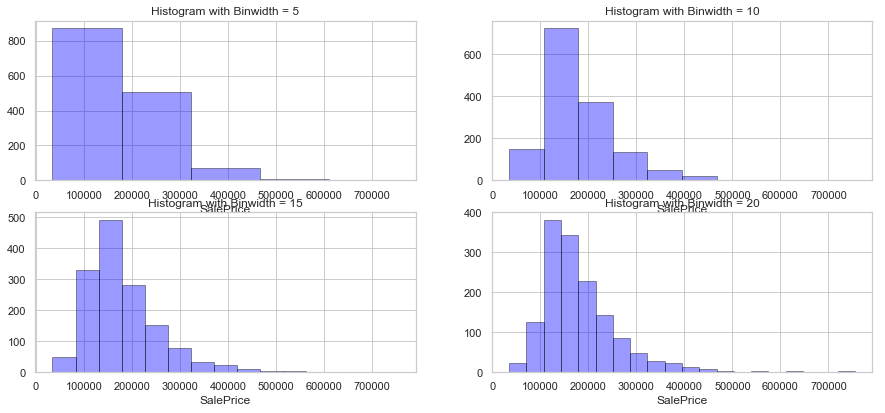

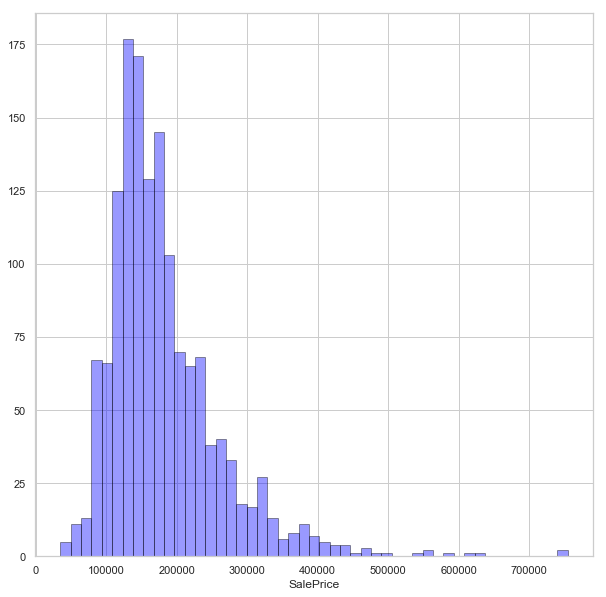

In [25]:
# Fetch numerical features and target variable
num_features = train_data.select_dtypes(include=np.number)
print('Number of Numerical features : ' + str(num_features.columns.size))

#Visualize how SalePrice is distributed.
plt.subplots(figsize=(15,10))
for i, binwidth in enumerate([5, 10, 15, 20]):
    # Set up the plot
    ax = plt.subplot(3, 2, i + 1)
    sns.distplot(num_features.SalePrice, hist=True, kde=False, bins=binwidth, color='blue', hist_kws={'edgecolor':'black'})
    ax.set_title('Histogram with Binwidth = %d' % binwidth)

plt.subplots(figsize=(10,10))
sns.distplot(num_features.SalePrice, kde=False, color='blue', hist_kws={'edgecolor':'black'})

In [26]:
'''
From above plots, we infer that
    a. SalePrice is Positive or Right Skewed.
    b. Linear Models require normally distributed data. So, we have apply transformation
       to remove/decrease skewness in SalePrice.
'''

'\nFrom above plots, we infer that\n    a. SalePrice is Positive or Right Skewed.\n    b. Linear Models require normally distributed data. So, we have apply transformation\n       to remove/decrease skewness in SalePrice.\n'

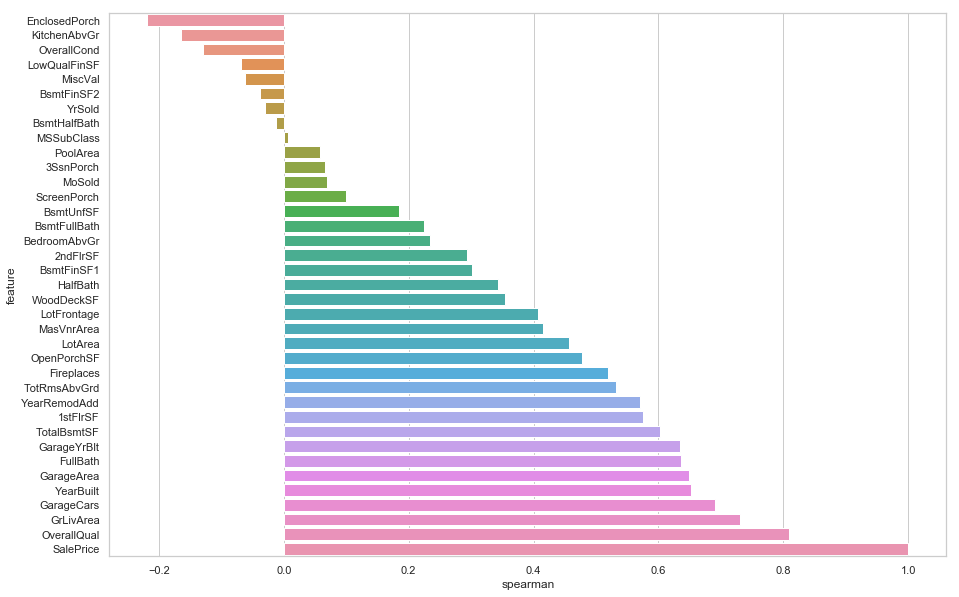

In [27]:
'''
To determin which features have more impact on SalePrice,
find correlation between features and SalePrice.
There are 2 correlations Pearson's and Spearman's.
Pearson's correlation assumes linear relationship between variables.
Spearman's correlation does not assume linear relationship between variables.
So, its better to go with Spearman's
'''

def find_spearman_corr(train_data, num_features_nms):
    sprearman_corr_df = pd.DataFrame()
    sprearman_corr_df['feature'] = num_features_nms
    sprearman_corr_df['spearman'] = \
            [train_data[f].corr(train_data['SalePrice'], 'spearman') \
             for f in num_features_nms]
    sprearman_corr_df = sprearman_corr_df.sort_values('spearman')
    plt.figure(figsize=(15,10))
    sns.barplot(data=sprearman_corr_df, y='feature', x='spearman')
    return sprearman_corr_df
    
sprearman_corr_df = find_spearman_corr(train_data, num_features.columns)

Text(0.5,1,'Spearman Correlation between features')

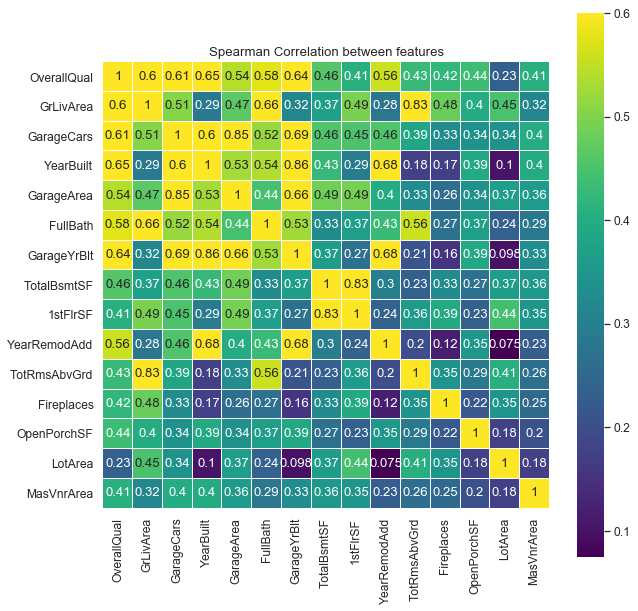

In [28]:
'''
Picked these features from correlation with SalePrice.
OverallQual, GrLivArea, GarageCars, YearBuilt, GarageArea, FullBath, GarageYrBlt,
TotalBsmtSF, 1stFlrSF, YearRemodAdd, TotRmsAbvGrd, Fireplaces, OpenPorchSF, 
LotArea, MasVnrArea.

Next Step, is to verify multi collinearity between selected features
'''

sig_num_cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'YearBuilt', 'GarageArea',
               'FullBath', 'GarageYrBlt', 'TotalBsmtSF', '1stFlrSF', 'YearRemodAdd',
               'TotRmsAbvGrd', 'Fireplaces', 'OpenPorchSF', 'LotArea', 'MasVnrArea']

spearman_corr = train_data[sig_num_cols].corr('spearman')

sns.set(font_scale=1.10)
plt.figure(figsize=(10, 10))
sns.heatmap(spearman_corr, vmax=.6, linewidths=0.01, square=True,annot=True,cmap='viridis',linecolor="white")
plt.title('Spearman Correlation between features')

In [29]:
'''
GrLivArea & TotRmsAbvGrd = 0.83
GarageCars & GarageArea = 0.85
YearBuilt & GarageYrBlt = 0.86
1stFlrSF & TotalBsmtSF = 0.83
YearRemodAdd with YearBuilt & GarageYrBlt = 0.68
GarageYrBlt & GarageArea = 0.66
GarageYrBlt & GarageCars = 0.69
FullBath & GrLivArea = 0.66


Exclude GrLivArea, GarageArea, GarageYrBlt, 1stFlrSF features owing to 
high correlation.

Final Numerical Features :
'OverallQual', 'GarageCars', 'YearBuilt','FullBath', 'TotalBsmtSF', 
'YearRemodAdd', 'TotRmsAbvGrd', 'Fireplaces', 'OpenPorchSF', 'LotArea', 
'MasVnrArea'
'''

"\nGrLivArea & TotRmsAbvGrd = 0.83\nGarageCars & GarageArea = 0.85\nYearBuilt & GarageYrBlt = 0.86\n1stFlrSF & TotalBsmtSF = 0.83\nYearRemodAdd with YearBuilt & GarageYrBlt = 0.68\nGarageYrBlt & GarageArea = 0.66\nGarageYrBlt & GarageCars = 0.69\nFullBath & GrLivArea = 0.66\n\n\nExclude GrLivArea, GarageArea, GarageYrBlt, 1stFlrSF features owing to \nhigh correlation.\n\nFinal Numerical Features :\n'OverallQual', 'GarageCars', 'YearBuilt','FullBath', 'TotalBsmtSF', \n'YearRemodAdd', 'TotRmsAbvGrd', 'Fireplaces', 'OpenPorchSF', 'LotArea', \n'MasVnrArea'\n"